# Geoffrey CIDERON 

## Graph Networks For Learning Heuristics For NP-Hard Combinatorial Optimization Problems

### Note: 

**For running the code Tensorflow, Graph Nets, CPLEX solver, Pyomo, Networkx, Numpy as too be installed. Futhermore,  models.py and replaymemory.py should be download as well.**

**To run the notebook without CPLEX, one has to comment in the before last cell the 5 lines that use CPLEX.**

In [14]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import models as m 
import replaymemory
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

# CPLEX
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
import pyomo.opt
import time


In [26]:

DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.
rand = np.random.RandomState(seed=1)

def generate_er_graph(rand,num_nodes_min_max,dimensions=2,p=0.3):
    # Sample num_nodes
    num_nodes = rand.randint(*num_nodes_min_max)
    
    # Create a directed ER graph with probability p 
    digraph = nx.fast_gnp_random_graph(num_nodes,p,directed=True)
    
    # Add weight on edge
    pos_array = rand.uniform(size=(num_nodes, 2))
    distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
    i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
    weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
    digraph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
    
    # Add the "uncovered" attribute to the nodes
    digraph.add_nodes_from(digraph.nodes(),tag=0)
    return digraph


def graph_to_input(graph):
    
    def create_feature(attr, fields):
        return np.hstack([np.array(attr[field], dtype=float) for field in fields])

    input_node_fields = ("tag",)
    input_edge_fields = ("distance",)

    input_graph = graph.copy()

    for node_index, node_feature in graph.nodes(data=True):
        input_graph.add_node(
            node_index, features=create_feature(node_feature, input_node_fields))

    for receiver, sender, features in graph.edges(data=True):
        input_graph.add_edge(
        sender, receiver, features=create_feature(features, input_edge_fields))

    input_graph.graph["features"] = np.array([0.0])
    
    return input_graph


def generate_networkx_graph(rand, num_nodes_min_max):
    
    graph = generate_er_graph(rand, num_nodes_min_max)
    input_graph = graph_to_input(graph)
    
    return input_graph, graph


def create_placeholder(rand, num_nodes_min_max):
    
    # Create some example data for inspecting the vector sizes.
    input_graph,_ = generate_networkx_graph(
      rand, num_nodes_min_max)
    input_ph = utils_tf.placeholders_from_networkxs(
      [input_graph], force_dynamic_num_graphs=True)
    
    return input_ph


def create_feed_dict(rand, num_nodes_min_max, input_ph):
    """ Return a GraphTuple, and the feed dict associated"""
    graph_tagged, _ = generate_networkx_graph(
      rand, num_nodes_min_max)
    input_graph = utils_np.networkxs_to_graphs_tuple([graph_tagged])
    feed_dict = {input_ph: input_graph}
    
    return input_graph,feed_dict, graph_tagged


def make_all_runnable_in_session(*args):
  """Lets an iterable of TF graphs be output from a session as NP graphs."""
  return [utils_tf.make_runnable_in_session(a) for a in args]


def update_tag(graph,S):
    """Update the tag of the nodes
    """
    _S = np.zeros((graph.n_node[0],1))
    _S[S] = 1
    return graph.replace(nodes=_S)
    
    
def cut_weight(graph,S):
    return np.sum([graph.edges[ind] for ind,i in enumerate(graph.receivers) if i in S and graph.senders[ind] not in S])


def batch_graphs_tuple(batch_graphs):
    """ From a batch of GraphTuple return a single GraphTuple """
    data_dicts = []
    for graph in batch_graphs:
        data_dicts.append(utils_np.graphs_tuple_to_data_dicts(graph)[0])
    return utils_np.data_dicts_to_graphs_tuple(data_dicts)


# Function used for the solver 
def create_maxcut_miqp(G):
    # create max cut problem MIQP with PyOMO
    maxcut = ConcreteModel()
    # 0-1 vars: 0 if node in S, 1 if in \bar{S}
    maxcut.y = Var(G.nodes(), within = Binary)
    # objective: max sum_{ij in E} w_ij * (y_i + y_j - 2 y_i*y_j)
    def max_cut(model):
            return sum(G[i][j]['distance'] * (model.y[i] + model.y[j] - 2*model.y[i]*model.y[j])  for (i,j) in G.edges())
    maxcut.maxcutobj = Objective(rule = max_cut, sense = maximize)
    return maxcut




In [16]:
tf.reset_default_graph()


seed = 2
rand = np.random.RandomState(seed=seed)

# Model parameters.


T = 5 # Number of processing (message-passing) steps (same notation T as in Dai et al. paper)

GAMMA = 1 # Discount factor

num_nodes_min_max_tr = (20, 30) # Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_test = (20,30) # Number of nodes per graph in the test set.

hidden_size_q_network = 32 # latent layers sizes for the Q_network 
latent_sizes_edge = [8,16]
latent_sizes_node = [8,16]
latent_sizes_global = [8,16]


# Input placeholders.
input_ph = create_placeholder(rand,num_nodes_min_max_tr)

# Collect the indices of allowed actions
mask = tf.equal(input_ph.nodes, tf.constant(0, dtype=tf.float64))
indices = tf.where(mask)[:,0]




# Connect the data to the model.
# Instantiate the model.
model = m.EncodeProcess(latent_sizes_edge, latent_sizes_node, latent_sizes_global)

output_graph = model(input_ph, T)

input_ph = make_all_runnable_in_session(input_ph)[0]

# Instantiate the Q network
Q = m.Q_network(hidden_size_q_network)

# Evaluation for a batch of actions but with a single graph
actions = output_graph.nodes
state = output_graph.globals


Q_map = Q.map_(state, actions)

# Create target_Q
Q_s_masked_a = tf.boolean_mask(Q_map,mask)

# Reward placeholder
reward = tf.placeholder(shape=[None,1], dtype=tf.float64)

target_Q = reward + GAMMA*tf.reduce_max(Q_s_masked_a,axis=[0])

# The indice of the node that maximize the Q function
ind = indices[tf.argmax(Q_s_masked_a,dimension=0)]



# Evaluation for a batch of actions and graphs

a = tf.placeholder(shape=[None, latent_sizes_node[-1]], dtype=tf.float64)
Q_s_a = Q(state, a)


# Loss
target = tf.placeholder(shape=[None, 1], dtype=tf.float64)
loss = tf.losses.huber_loss(target, Q_s_a)

# Optimizer.
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step,
                                           1000, 0.95, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
step = optimizer.minimize(loss,global_step = global_step)



# Variables initialisations
init_op = tf.global_variables_initializer()


    

In [18]:
## Q-learning For The Greedy Algorithm
nb_episodes = 200
memory = replaymemory.ReplayMemory(1000)
n = 2 


EPS_START = 0.95 
EPS_END = 0.05
EPS_DECAY = 1000
BATCH_SIZE = 64

### 
try:
    sess.close()
except NameError:
    pass

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(init_op)

###


steps_done = 0

def select_action(graph,S):
    '''
    Given a graph and a list of already chosen nodes, 
    choose a node to pick either randomly (exploration)
    or according to the Q-function (explotation)
    '''
    
    global steps_done
    sample = np.random.rand()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # Choose the best vertice to add 
        ind_run = sess.run(ind,feed_dict={input_ph: graph})
        return ind_run 
    else:
        _S = np.arange(graph.n_node[0])
        _S[S] = -1
        return np.random.choice(_S[_S>-1])
    
    
def create_batch_graphs(rand, num_nodes_min_max, input_ph, batch_size = 30):
    """ Return a batch of GraphsTuples"""
    graphs = []
    graphs_tagged = []
    for _ in range(batch_size):
        input_graph, _, graph_tagged = create_feed_dict(rand, num_nodes_min_max, input_ph)
        graphs.append(input_graph)
        graphs_tagged.append(graph_tagged)
    return graphs, graphs_tagged
    


def maxcut_with_solver(graphs,solver):
    """
    Args: 
    graphs: list of Networkx graphs tagged with the distance feature
    solver: a solver 
    Return: the average maxcut calculated  by the solver 
    """
    maxcut = 0
    for graph in graphs:
        miqp = create_maxcut_miqp(graph.to_undirected())
        results = solver.solve(miqp, keepfiles = False, tee = False)
        miqp.solutions.load_from(results)
        maxcut += miqp.maxcutobj()
    return maxcut/len(graphs)


def maxcut_with_Q(graphs):
    '''
    Args: 
    graphs: list of GraphTuples
    Return: the average maxcut calculated by Q
    '''
    maxcut = 0
    for graph in graphs:
        S = []
        cut = 0
        cut_old = -1
        gr = update_tag(graph,S)
        n_nodes = graph.n_node[0]
        t = 0
        while cut > cut_old and t < n_nodes :
            cut_old = cut
            ind_run = sess.run(ind,feed_dict={input_ph: gr})
            S.append(ind_run)
            cut = cut_weight(gr,S)
            gr = update_tag(graph,S)
            t += 1 
        maxcut += cut
    return maxcut/len(graphs)
    

# Create the test set 
graphs_test, graphs_tagged_test = create_batch_graphs(rand, num_nodes_min_max_test, input_ph, batch_size = 50)


# solve MIQP using CPLEX
cplexTimeLimit = 100
solver = pyomo.opt.SolverFactory("cplex",executable ='/opt/ibm/ILOG/CPLEX_Studio_Community128/cplex/bin/x86-64_linux/cplex',warnings="ignore") #ipopt 'cplexamp', solver_io = 'nl')
solver.options['timelimit'] = cplexTimeLimit
solver.options['threads'] = 24

maxcut_solver_test = maxcut_with_solver(graphs_tagged_test,solver)
print("Maxcut on the test set calculated by the solver: {:.4f}".format(maxcut_solver_test))
del graphs_tagged_test # it won't be re-used

maxcuts_test = [] # List of the performance of the learned greedy policy on the testset
graphs_drawn = [] # Historic of all the graphs drawn
loss_train = []
steps_done_ep = [] # List of steps done
approximation_ratios = [] # Approximation ratio of the learned greedy policy on the testset
for e in range(nb_episodes+1): 
    
    # Try the learned greedy policy on a testset
    if e%5==0 or e==0:
        print("episode:",e)
        mcut = maxcut_with_Q(graphs_test)
        maxcuts_test.append(mcut)
        steps_done_ep.append(steps_done)
        ap_ratio = max(maxcut_solver_test/mcut, mcut/maxcut_solver_test)
        approximation_ratios.append(ap_ratio)
        print("On the testset average cut: {:.4f}, R: {:.4f} after {} steps".format(mcut,ap_ratio,steps_done))
        if e > 0:
            print("loss: {:.6f}".format(train_values["loss"]))
    input_graph, feed_dict, raw_graph = create_feed_dict(rand, num_nodes_min_max_tr, input_ph)
    S = [] # Initialize the list of chosen nodes to empty
    cut = 0 # Initial cut value of the set of chosen vertices S
    n_nodes = input_graph.n_node[0]
    rewards = []
    graphs_drawn.append(input_graph)
    for t in range(1,input_graph.n_node[0]+1):
        cut_old = cut
        input_graph = update_tag(input_graph,S)
        v = select_action(input_graph,S)
        S.append(v)
        input_graph = update_tag(input_graph,S)
        cut = cut_weight(input_graph,S) # new value of cut
        if cut - cut_old > 0:
            rewards.append(cut - cut_old)
        else: # stop if the cut can not be improved
            S = S[:-1]
            break
        if t >= n:
            memory.push(S[:-n],S[-n],np.sum(rewards[-n:]),S,e)
            bs = max(min(memory.position,BATCH_SIZE),1)
            B = memory.sample(bs)
            target_Qs = []
            batch_graphs = []
            acts = []
            for i, play in enumerate(B):
                state, id_action, r, next_state, ep = play
                graph_sampled = graphs_drawn[ep]
                graph_sampled = update_tag(graph_sampled,next_state)
                t_Q, act = sess.run([target_Q, actions],{input_ph: graph_sampled, reward: [[r]]})
                act = act[id_action]
                target_Qs.append(t_Q)
                acts.append(act)
                batch_graphs.append(graph_sampled)
            acts = np.reshape(acts, [-1, act.size])
            target_Qs = np.vstack(target_Qs)
            train_values = sess.run({
                "step": step,
                "loss": loss 
            },feed_dict={input_ph: batch_graphs_tuple(batch_graphs), a: acts, target: target_Qs})
            loss_train.append(train_values["loss"])
    

Maxcut on the test set calculated by the solver: 95.4477
episode: 0
On the testset average cut: 75.9920, R: 1.2560 after 0 steps
episode: 5
On the testset average cut: 80.1963, R: 1.1902 after 68 steps
loss: 12.238852
episode: 10
On the testset average cut: 79.1950, R: 1.2052 after 129 steps
loss: 12.970428
episode: 15
On the testset average cut: 78.9543, R: 1.2089 after 194 steps
loss: 12.971191
episode: 20
On the testset average cut: 79.9161, R: 1.1943 after 258 steps
loss: 10.695312
episode: 25
On the testset average cut: 79.8908, R: 1.1947 after 317 steps
loss: 12.960938
episode: 30
On the testset average cut: 79.9980, R: 1.1931 after 378 steps
loss: 12.632812
episode: 35
On the testset average cut: 79.6521, R: 1.1983 after 438 steps
loss: 15.093750
episode: 40
On the testset average cut: 77.0615, R: 1.2386 after 500 steps
loss: 9.195312
episode: 45
On the testset average cut: 78.6482, R: 1.2136 after 562 steps
loss: 11.015625
episode: 50
On the testset average cut: 79.3395, R: 1.2

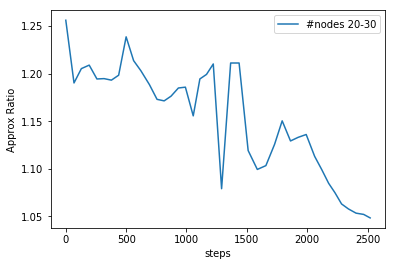

In [25]:
plt.plot(steps_done_ep, approximation_ratios, label = "#nodes 20-30")
plt.xlabel("steps")
plt.ylabel("Approx Ratio")
plt.legend(loc="best")
plt.show()